# Coparying ASC across isobaths

In [1]:
# Load necessary modules
import intake
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram
import warnings
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(threads_per_worker = 1)

2025-10-22 09:28:02,173 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('pandas_cut_wrapper_0-d936854e0972e1771da0ad37f17a53ed', 0) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: Alias(('pandas_cut_wrapper_0-d936854e0972e1771da0ad37f17a53ed', 0)->('pandas_cut_wrapper-pandas_cut_wrapper_0-d936854e0972e1771da0ad37f17a53ed', 0))
new run_spec: Alias(('pandas_cut_wrapper_0-d936854e0972e1771da0ad37f17a53ed', 0)->('broadcast_to-concatenate-getitem-open_dataset-original-pandas_cut_wrapper-pandas_cut_wrapper_0-d936854e0972e1771da0--ef1', 0))
old dependencies: {('pandas_cut_wrapper-pandas_cut_wrapper_0-d93

In [3]:
catalog = intake.cat.access_nri
ylength=580

In [4]:
VELs_650m = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_z/OM2_IAF_XYgrid_650m/*.nc')
VELs_1500m = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_z/OM2_IAF_XYgrid_1500m/*.nc')
VELs_1000m = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_z/OM2_IAF_XYgrid/*.nc')

In [10]:
%%time
#Calculating the time-mean of ASC in different isobaths
ASC_650m_mean = VELs_650m.u_along_contour.mean('time').compute()
ASC_1500m_mean = VELs_1500m.u_along_contour.mean('time').compute()
ASC_1000m_mean = VELs_1000m.u_along_contour.mean('time').compute()

#Calculating the standard deviations of ASC in different isobaths
ASC_650m_std = VELs_650m.u_along_contour.std('time').compute()
ASC_1500m_std = VELs_1500m.u_along_contour.std('time').compute()
ASC_1000m_std = VELs_1000m.u_along_contour.std('time').compute()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


CPU times: user 33.2 s, sys: 18.5 s, total: 51.7 s
Wall time: 1min 7s


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [11]:
#in this definition, no frequency can be used only for static data
def importer(experiment,catalog,variable, frequency = 'fx',start_time=0,end_time=0):
    warnings.filterwarnings('ignore')
    if experiment== "panant-01-zstar-ACCESSyr2":
        var = catalog[experiment].search(variable=variable, frequency = frequency).to_dask(xarray_open_kwargs={'decode_timedelta':True})
    else: 
        #other resolutions have the same variable with z_l and z_l_sub z dim in different times.
        # I will filter to the time I want knowing th their specificities
        #IOW this fix works just for the models and variables used in this notebook
        if variable=='uo' or variable=='vo':
            var = catalog[experiment].search(variable=variable, frequency = frequency)
            keysnames = var.keys() ; search_term = "z_l_sub01"
            matches = [s for s in keysnames if search_term in s]
            var = catalog[experiment].search(variable=variable, frequency = frequency,file_id = matches).to_dask(xarray_open_kwargs={'decode_timedelta':True})
        else:
            var = catalog[experiment].search(variable=variable, frequency = frequency).to_dask(xarray_open_kwargs={'decode_timedelta':True})
    
    if start_time!=0:
        time_slice='slice(start_time,end_time)'
        return eval("var." + variable + ".sel(time=" + time_slice + ")")
    elif start_time ==0:
        return eval("var." + variable)

averaging ASC over a depth range, and smoothing it with a 3 degree rolling mean for reduced noise

In [12]:
# gathering dzt weights for vertical average
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
#importing mean dzt for weighting
dzt = importer(iaf_cycle3,catalog,'dzt',frequency='1mon').isel(time=slice(0,12)).sel(yt_ocean=slice(-90,-60)).mean(('time','xt_ocean','yt_ocean')).compute()

In [14]:
#averaging quantities
depth_slice=slice(0,200) #depth to average
bin_edges=np.arange(-280,83,10)

#calculating the means over top 200m
ASC_1000m_mean_z200 = ASC_1000m_mean.sel(st_ocean=depth_slice).weighted(dzt).mean('st_ocean')
ASC_650m_mean_z200 = ASC_650m_mean.sel(st_ocean=depth_slice).weighted(dzt).mean('st_ocean')
ASC_1500m_mean_z200 = ASC_1500m_mean.sel(st_ocean=depth_slice).weighted(dzt).mean('st_ocean')


#binning in 3 degree bins - 1000 m isobath and smoothing
ASC_1000m_mean_z200['lon_along_contour'] = VELs_1000m.lon_along_contour.isel(time=0)
labels_degs = ASC_1000m_mean_z200['lon_along_contour'].groupby_bins('lon_along_contour',bins=bin_edges,restore_coord_dims=True).mean().compute()
ASC_1000m_mean_z200_degs = ASC_1000m_mean_z200.groupby_bins('lon_along_contour',bins=bin_edges).mean().compute()
ASC_1000m_mean_z200_degs['lon_along_contour_bins'] = labels_degs; 
longs_sorted_1000m = np.sort(VELs_1000m.lon_along_contour.isel(time=0).values)
ASC_1000m_mean_z200_degs = ASC_1000m_mean_z200_degs.interp(lon_along_contour_bins= longs_sorted_1000m ,method="quadratic")

#binning in 3 degree bins - 1500 m isobath and smoothing
ASC_1500m_mean_z200['lon_along_contour'] = VELs_1500m.lon_along_contour.isel(time=0)
labels_degs = ASC_1500m_mean_z200['lon_along_contour'].groupby_bins('lon_along_contour',bins=bin_edges,restore_coord_dims=True).mean().compute()
ASC_1500m_mean_z200_degs = ASC_1500m_mean_z200.groupby_bins('lon_along_contour',bins=bin_edges).mean().compute()
ASC_1500m_mean_z200_degs['lon_along_contour_bins'] = labels_degs; 
longs_sorted_1500m = np.sort(VELs_1500m.lon_along_contour.isel(time=0).values)
ASC_1500m_mean_z200_degs = ASC_1500m_mean_z200_degs.interp(lon_along_contour_bins= longs_sorted_1500m ,method="quadratic")

#binning in 3 degree bins - 650 m isobath and smoothing
ASC_650m_mean_z200['lon_along_contour'] = VELs_650m.lon_along_contour.isel(time=0)
labels_degs = ASC_650m_mean_z200['lon_along_contour'].groupby_bins('lon_along_contour',bins=bin_edges,restore_coord_dims=True).mean().compute()
ASC_650m_mean_z200_degs = ASC_650m_mean_z200.groupby_bins('lon_along_contour',bins=bin_edges).mean().compute()
ASC_650m_mean_z200_degs['lon_along_contour_bins'] = labels_degs; 
longs_sorted_650m = np.sort(VELs_650m.lon_along_contour.isel(time=0).values)
ASC_650m_mean_z200_degs = ASC_650m_mean_z200_degs.interp(lon_along_contour_bins= longs_sorted_650m ,method="quadratic")


Now same for the standard deviations

In [15]:
#calculating the STD means over top 200m
ASC_1000m_mean_z200_std = ASC_1000m_std.sel(st_ocean=depth_slice).weighted(dzt).mean('st_ocean')
ASC_650m_mean_z200_std = ASC_650m_std.sel(st_ocean=depth_slice).weighted(dzt).mean('st_ocean')
ASC_1500m_mean_z200_std = ASC_1500m_std.sel(st_ocean=depth_slice).weighted(dzt).mean('st_ocean')


#binning in 3 degree bins - 1000 m isobath and smoothing
ASC_1000m_mean_z200_std['lon_along_contour'] = VELs_1000m.lon_along_contour.isel(time=0)
labels_degs = ASC_1000m_mean_z200['lon_along_contour'].groupby_bins('lon_along_contour',bins=bin_edges,restore_coord_dims=True).mean().compute()
ASC_1000m_mean_z200_std_degs = ASC_1000m_mean_z200_std.groupby_bins('lon_along_contour',bins=bin_edges).mean().compute()
ASC_1000m_mean_z200_std_degs['lon_along_contour_bins'] = labels_degs; 
longs_sorted_1000m = np.sort(VELs_1000m.lon_along_contour.isel(time=0).values)
ASC_1000m_mean_z200_std_degs = ASC_1000m_mean_z200_std_degs.interp(lon_along_contour_bins= longs_sorted_1000m ,method="quadratic")

# #binning in 3 degree bins - 1500 m isobath and smoothing
ASC_1500m_mean_z200_std['lon_along_contour'] = VELs_1500m.lon_along_contour.isel(time=0)
labels_degs = ASC_1500m_mean_z200['lon_along_contour'].groupby_bins('lon_along_contour',bins=bin_edges,restore_coord_dims=True).mean().compute()
ASC_1500m_mean_z200_std_degs = ASC_1500m_mean_z200_std.groupby_bins('lon_along_contour',bins=bin_edges).mean().compute()
ASC_1500m_mean_z200_std_degs['lon_along_contour_bins'] = labels_degs; 
longs_sorted_1500m = np.sort(VELs_1500m.lon_along_contour.isel(time=0).values)
ASC_1500m_mean_z200_std_degs = ASC_1500m_mean_z200_std_degs.interp(lon_along_contour_bins= longs_sorted_1500m ,method="quadratic")

# #binning in 3 degree bins - 650 m isobath and smoothing
ASC_650m_mean_z200_std['lon_along_contour'] = VELs_650m.lon_along_contour.isel(time=0)
labels_degs = ASC_650m_mean_z200['lon_along_contour'].groupby_bins('lon_along_contour',bins=bin_edges,restore_coord_dims=True).mean().compute()
ASC_650m_mean_z200_std_degs = ASC_650m_mean_z200_std.groupby_bins('lon_along_contour',bins=bin_edges).mean().compute()
ASC_650m_mean_z200_std_degs['lon_along_contour_bins'] = labels_degs; 
longs_sorted_650m = np.sort(VELs_650m.lon_along_contour.isel(time=0).values)
ASC_650m_mean_z200_std_degs = ASC_650m_mean_z200_std_degs.interp(lon_along_contour_bins= longs_sorted_650m ,method="quadratic")


Importing depths for bathymetry plots

In [16]:
depth = importer(iaf_cycle3,catalog,'ht',frequency='fx').sel(yt_ocean=slice(-90,-50)).compute()
depth0 = depth.fillna(0)

Let's also correlate the ASC in different isobaths to show that their variability is basically the same

In [17]:
%%time
#Calculating the time-mean of ASC in different isobaths
ASC_650m_mean = VELs_650m.u_along_contour.mean('time').compute()
ASC_1500m_mean = VELs_1500m.u_along_contour.mean('time').compute()
ASC_1000m_mean = VELs_1000m.u_along_contour.mean('time').compute()

#Calculating the standard deviations of ASC in different isobaths
ASC_650m_std = VELs_650m.u_along_contour.std('time').compute()
ASC_1500m_std = VELs_1500m.u_along_contour.std('time').compute()
ASC_1000m_std = VELs_1000m.u_along_contour.std('time').compute()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


CPU times: user 31.5 s, sys: 17.1 s, total: 48.6 s
Wall time: 1min 2s


In [18]:
#binning the ASC speeds in 10 degrees prior to calcualting correlations
VELs_650m_binned = VELs_650m.sel(st_ocean=depth_slice).weighted(dzt).mean('st_ocean').groupby_bins('lon_along_contour',bins=bin_edges).mean('contour_index')
VELs_650m_binned['lon_along_contour_bins'] = labels_degs 
VELs_1000m_binned = VELs_1000m.sel(st_ocean=depth_slice).weighted(dzt).mean('st_ocean').groupby_bins('lon_along_contour',bins=bin_edges).mean('contour_index')
VELs_1000m_binned['lon_along_contour_bins'] = labels_degs 
VELs_1500m_binned = VELs_1500m.sel(st_ocean=depth_slice).weighted(dzt).mean('st_ocean').groupby_bins('lon_along_contour',bins=bin_edges).mean('contour_index')
VELs_1500m_binned['lon_along_contour_bins'] = labels_degs 

Calculating correlations in each bin

In [19]:
%%time
R2_1000m_650m= ((xr.corr(VELs_650m_binned.u_along_contour,VELs_1000m_binned.u_along_contour,dim = 'time'))**2).compute()
R2_1000m_1500m= ((xr.corr(VELs_1500m_binned.u_along_contour,VELs_1000m_binned.u_along_contour,dim = 'time'))**2).compute()

CPU times: user 1min 12s, sys: 6.67 s, total: 1min 19s
Wall time: 1min 19s


In [20]:
%%time
#correlations of mean circumpolar ASC
R2_1000m_650m_Cmean= ((xr.corr(VELs_650m_binned.u_along_contour.mean('lon_along_contour_bins'),VELs_1000m_binned.u_along_contour.mean('lon_along_contour_bins'),dim = 'time'))**2).compute()
R2_1000m_1500m_Cmean= ((xr.corr(VELs_1500m_binned.u_along_contour.mean('lon_along_contour_bins'),VELs_1000m_binned.u_along_contour.mean('lon_along_contour_bins'),dim = 'time'))**2).compute()


CPU times: user 1min 14s, sys: 6.44 s, total: 1min 21s
Wall time: 1min 21s


In [21]:
R2_1000m_650m_Cmean,R2_1000m_1500m_Cmean

(<xarray.DataArray 'u_along_contour' ()> Size: 4B
 array(0.9431501, dtype=float32),
 <xarray.DataArray 'u_along_contour' ()> Size: 4B
 array(0.97161347, dtype=float32))

In [22]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
longitude_inds = np.array([5,36-15, 14, 3,10,17,36-12,36-10, 36-1,1])
regions_abridged = ['Mertz','WAP', 'Getz', 'Totten',\
           'Glomar', 'Amundsen', 'Filchner', \
           'Riiser-Larsen', 'Amery', 'Denman']

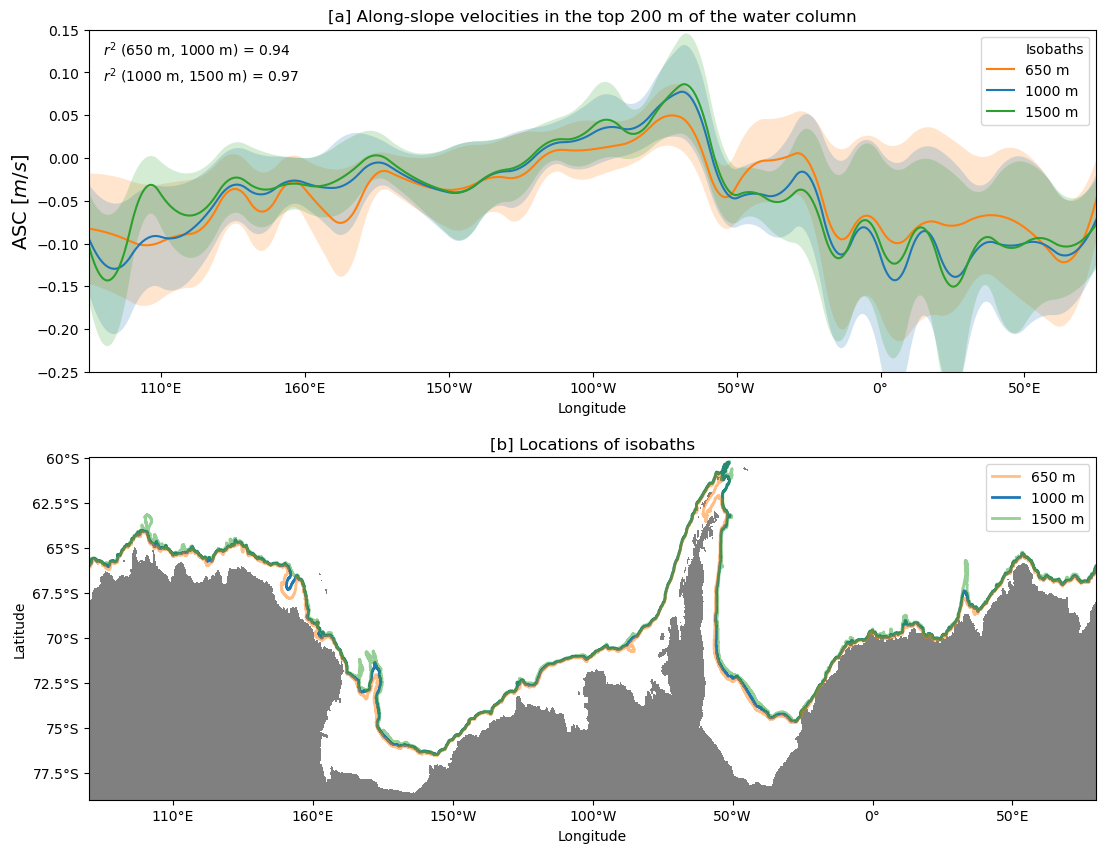

In [23]:
## plot

plt.figure(figsize=(13,10))
plt.subplots_adjust(hspace=0.25)

ax0 = plt.subplot(2,1,1)
#650m and std
plt.plot([],[],color='w',label='Isobaths')
plt.plot(ASC_650m_mean_z200_degs.lon_along_contour_bins,ASC_650m_mean_z200_degs,label='650 m',color='tab:orange')
plt.fill_between(ASC_650m_mean_z200_degs.lon_along_contour_bins, y1=ASC_650m_mean_z200_degs-ASC_650m_mean_z200_std_degs, \
                 y2=ASC_650m_mean_z200_degs+ASC_650m_mean_z200_std_degs,alpha=0.2,color='tab:orange',edgecolor='none')

#1000 m and std
plt.plot(ASC_1000m_mean_z200_degs.lon_along_contour_bins,ASC_1000m_mean_z200_degs,label='1000 m',color='tab:blue')
plt.fill_between(ASC_1000m_mean_z200_degs.lon_along_contour_bins, y1=ASC_1000m_mean_z200_degs-ASC_1000m_mean_z200_std_degs, \
                 y2=ASC_1000m_mean_z200_degs+ASC_1000m_mean_z200_std_degs,alpha=0.2,color='tab:blue',edgecolor='none')

plt.plot(ASC_1500m_mean_z200_degs.lon_along_contour_bins,ASC_1500m_mean_z200_degs,label='1500 m',color='tab:green')
plt.fill_between(ASC_1500m_mean_z200_degs.lon_along_contour_bins, y1=ASC_1500m_mean_z200_degs-ASC_1500m_mean_z200_std_degs, \
                 y2=ASC_1500m_mean_z200_degs+ASC_1500m_mean_z200_std_degs,alpha=0.2,color='tab:green',edgecolor='none')
plt.legend()
plt.ylabel(r'ASC [$m/s$]',fontsize=14)
plt.xlim(-275,75)
plt.ylim(-0.25,0.15)
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude')
plt.title('[a] Along-slope velocities in the top 200 m of the water column')
plt.text(-270,0.12,r'$r^2$ (650 m, 1000 m) = ' + str(np.round(R2_1000m_650m_Cmean,2).values))
plt.text(-270,0.09,r'$r^2$ (1000 m, 1500 m) = ' + str(np.round(R2_1000m_1500m_Cmean,2).values))

ax1 = plt.subplot(2,1,2)
plt.contourf(depth0.xt_ocean,depth0.yt_ocean,depth0,levels=[0,1],colors='grey')
plt.plot(VELs_650m.lon_along_contour.isel(time=0),VELs_650m.lat_along_contour.isel(time=0),color='tab:orange',linewidth=2,label='650 m',alpha=0.5)
plt.plot(VELs_1000m.lon_along_contour.isel(time=0),VELs_1000m.lat_along_contour.isel(time=0),color='tab:blue',linewidth=2,label='1000 m',zorder=0)
plt.plot(VELs_1500m.lon_along_contour.isel(time=0),VELs_1500m.lat_along_contour.isel(time=0),color='tab:green',linewidth=2,label='1500 m',alpha=0.5)
plt.ylim(-79,-60);plt.xlim(-280,80);plt.legend()
ax1.xaxis.set_major_formatter(LongitudeFormatter()); plt.xlabel('Longitude')
ax1.yaxis.set_major_formatter(LatitudeFormatter()); plt.ylabel('Latitude')
plt.title('[b] Locations of isobaths')

plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/ASC_3_isobaths.png',dpi=300,bbox_inches='tight')

## Full depth ASC

In [45]:
#averaging quantities
#depth_slice=slice(400,600) #depth to average
bin_edges=np.arange(-280,83,10)

#calculating the means over top 200m
ASC_1000m_mean_z200 = ASC_1000m_mean.weighted(dzt).mean('st_ocean')
ASC_650m_mean_z200 = ASC_650m_mean.weighted(dzt).mean('st_ocean')
ASC_1500m_mean_z200 = ASC_1500m_mean.weighted(dzt).mean('st_ocean')


#binning in 3 degree bins - 1000 m isobath and smoothing
ASC_1000m_mean_z200['lon_along_contour'] = VELs_1000m.lon_along_contour.isel(time=0)
labels_degs = ASC_1000m_mean_z200['lon_along_contour'].groupby_bins('lon_along_contour',bins=bin_edges,restore_coord_dims=True).mean().compute()
ASC_1000m_mean_z200_degs = ASC_1000m_mean_z200.groupby_bins('lon_along_contour',bins=bin_edges).mean().compute()
ASC_1000m_mean_z200_degs['lon_along_contour_bins'] = labels_degs; 
longs_sorted_1000m = np.sort(VELs_1000m.lon_along_contour.isel(time=0).values)
ASC_1000m_mean_z200_degs = ASC_1000m_mean_z200_degs.interp(lon_along_contour_bins= longs_sorted_1000m ,method="quadratic")

#binning in 3 degree bins - 1500 m isobath and smoothing
ASC_1500m_mean_z200['lon_along_contour'] = VELs_1500m.lon_along_contour.isel(time=0)
labels_degs = ASC_1500m_mean_z200['lon_along_contour'].groupby_bins('lon_along_contour',bins=bin_edges,restore_coord_dims=True).mean().compute()
ASC_1500m_mean_z200_degs = ASC_1500m_mean_z200.groupby_bins('lon_along_contour',bins=bin_edges).mean().compute()
ASC_1500m_mean_z200_degs['lon_along_contour_bins'] = labels_degs; 
longs_sorted_1500m = np.sort(VELs_1500m.lon_along_contour.isel(time=0).values)
ASC_1500m_mean_z200_degs = ASC_1500m_mean_z200_degs.interp(lon_along_contour_bins= longs_sorted_1500m ,method="quadratic")

#binning in 3 degree bins - 650 m isobath and smoothing
ASC_650m_mean_z200['lon_along_contour'] = VELs_650m.lon_along_contour.isel(time=0)
labels_degs = ASC_650m_mean_z200['lon_along_contour'].groupby_bins('lon_along_contour',bins=bin_edges,restore_coord_dims=True).mean().compute()
ASC_650m_mean_z200_degs = ASC_650m_mean_z200.groupby_bins('lon_along_contour',bins=bin_edges).mean().compute()
ASC_650m_mean_z200_degs['lon_along_contour_bins'] = labels_degs; 
longs_sorted_650m = np.sort(VELs_650m.lon_along_contour.isel(time=0).values)
ASC_650m_mean_z200_degs = ASC_650m_mean_z200_degs.interp(lon_along_contour_bins= longs_sorted_650m ,method="quadratic")


In [46]:
#calculating the STD means over top 200m
ASC_1000m_mean_z200_std = ASC_1000m_std.weighted(dzt).mean('st_ocean')
ASC_650m_mean_z200_std = ASC_650m_std.weighted(dzt).mean('st_ocean')
ASC_1500m_mean_z200_std = ASC_1500m_std.weighted(dzt).mean('st_ocean')


#binning in 3 degree bins - 1000 m isobath and smoothing
ASC_1000m_mean_z200_std['lon_along_contour'] = VELs_1000m.lon_along_contour.isel(time=0)
labels_degs = ASC_1000m_mean_z200['lon_along_contour'].groupby_bins('lon_along_contour',bins=bin_edges,restore_coord_dims=True).mean().compute()
ASC_1000m_mean_z200_std_degs = ASC_1000m_mean_z200_std.groupby_bins('lon_along_contour',bins=bin_edges).mean().compute()
ASC_1000m_mean_z200_std_degs['lon_along_contour_bins'] = labels_degs; 
longs_sorted_1000m = np.sort(VELs_1000m.lon_along_contour.isel(time=0).values)
ASC_1000m_mean_z200_std_degs = ASC_1000m_mean_z200_std_degs.interp(lon_along_contour_bins= longs_sorted_1000m ,method="quadratic")

# #binning in 3 degree bins - 1500 m isobath and smoothing
ASC_1500m_mean_z200_std['lon_along_contour'] = VELs_1500m.lon_along_contour.isel(time=0)
labels_degs = ASC_1500m_mean_z200['lon_along_contour'].groupby_bins('lon_along_contour',bins=bin_edges,restore_coord_dims=True).mean().compute()
ASC_1500m_mean_z200_std_degs = ASC_1500m_mean_z200_std.groupby_bins('lon_along_contour',bins=bin_edges).mean().compute()
ASC_1500m_mean_z200_std_degs['lon_along_contour_bins'] = labels_degs; 
longs_sorted_1500m = np.sort(VELs_1500m.lon_along_contour.isel(time=0).values)
ASC_1500m_mean_z200_std_degs = ASC_1500m_mean_z200_std_degs.interp(lon_along_contour_bins= longs_sorted_1500m ,method="quadratic")

# #binning in 3 degree bins - 650 m isobath and smoothing
ASC_650m_mean_z200_std['lon_along_contour'] = VELs_650m.lon_along_contour.isel(time=0)
labels_degs = ASC_650m_mean_z200['lon_along_contour'].groupby_bins('lon_along_contour',bins=bin_edges,restore_coord_dims=True).mean().compute()
ASC_650m_mean_z200_std_degs = ASC_650m_mean_z200_std.groupby_bins('lon_along_contour',bins=bin_edges).mean().compute()
ASC_650m_mean_z200_std_degs['lon_along_contour_bins'] = labels_degs; 
longs_sorted_650m = np.sort(VELs_650m.lon_along_contour.isel(time=0).values)
ASC_650m_mean_z200_std_degs = ASC_650m_mean_z200_std_degs.interp(lon_along_contour_bins= longs_sorted_650m ,method="quadratic")


In [47]:
%%time
#Calculating the time-mean of ASC in different isobaths
ASC_650m_mean = VELs_650m.u_along_contour.mean('time').compute()
ASC_1500m_mean = VELs_1500m.u_along_contour.mean('time').compute()
ASC_1000m_mean = VELs_1000m.u_along_contour.mean('time').compute()

#Calculating the standard deviations of ASC in different isobaths
ASC_650m_std = VELs_650m.u_along_contour.std('time').compute()
ASC_1500m_std = VELs_1500m.u_along_contour.std('time').compute()
ASC_1000m_std = VELs_1000m.u_along_contour.std('time').compute()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


CPU times: user 33.4 s, sys: 17.4 s, total: 50.8 s
Wall time: 1min 3s


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [48]:
#binning the ASC speeds in 10 degrees prior to calcualting correlations
VELs_650m_binned = VELs_650m.weighted(dzt).mean('st_ocean').groupby_bins('lon_along_contour',bins=bin_edges).mean('contour_index')
VELs_650m_binned['lon_along_contour_bins'] = labels_degs 
VELs_1000m_binned = VELs_1000m.weighted(dzt).mean('st_ocean').groupby_bins('lon_along_contour',bins=bin_edges).mean('contour_index')
VELs_1000m_binned['lon_along_contour_bins'] = labels_degs 
VELs_1500m_binned = VELs_1500m.weighted(dzt).mean('st_ocean').groupby_bins('lon_along_contour',bins=bin_edges).mean('contour_index')
VELs_1500m_binned['lon_along_contour_bins'] = labels_degs 

In [49]:
%%time
R2_1000m_650m= ((xr.corr(VELs_650m_binned.u_along_contour,VELs_1000m_binned.u_along_contour,dim = 'time'))**2).compute()
R2_1000m_1500m= ((xr.corr(VELs_1500m_binned.u_along_contour,VELs_1000m_binned.u_along_contour,dim = 'time'))**2).compute()

CPU times: user 1min 20s, sys: 7.03 s, total: 1min 27s
Wall time: 1min 27s


In [50]:
%%time
#correlations of mean circumpolar ASC
R2_1000m_650m_Cmean= ((xr.corr(VELs_650m_binned.u_along_contour.mean('lon_along_contour_bins'),VELs_1000m_binned.u_along_contour.mean('lon_along_contour_bins'),dim = 'time'))**2).compute()
R2_1000m_1500m_Cmean= ((xr.corr(VELs_1500m_binned.u_along_contour.mean('lon_along_contour_bins'),VELs_1000m_binned.u_along_contour.mean('lon_along_contour_bins'),dim = 'time'))**2).compute()


CPU times: user 1min 21s, sys: 7.11 s, total: 1min 28s
Wall time: 1min 28s


In [51]:
R2_1000m_650m_Cmean,R2_1000m_1500m_Cmean

(<xarray.DataArray 'u_along_contour' ()> Size: 4B
 array(0.929052, dtype=float32),
 <xarray.DataArray 'u_along_contour' ()> Size: 4B
 array(0.97293514, dtype=float32))

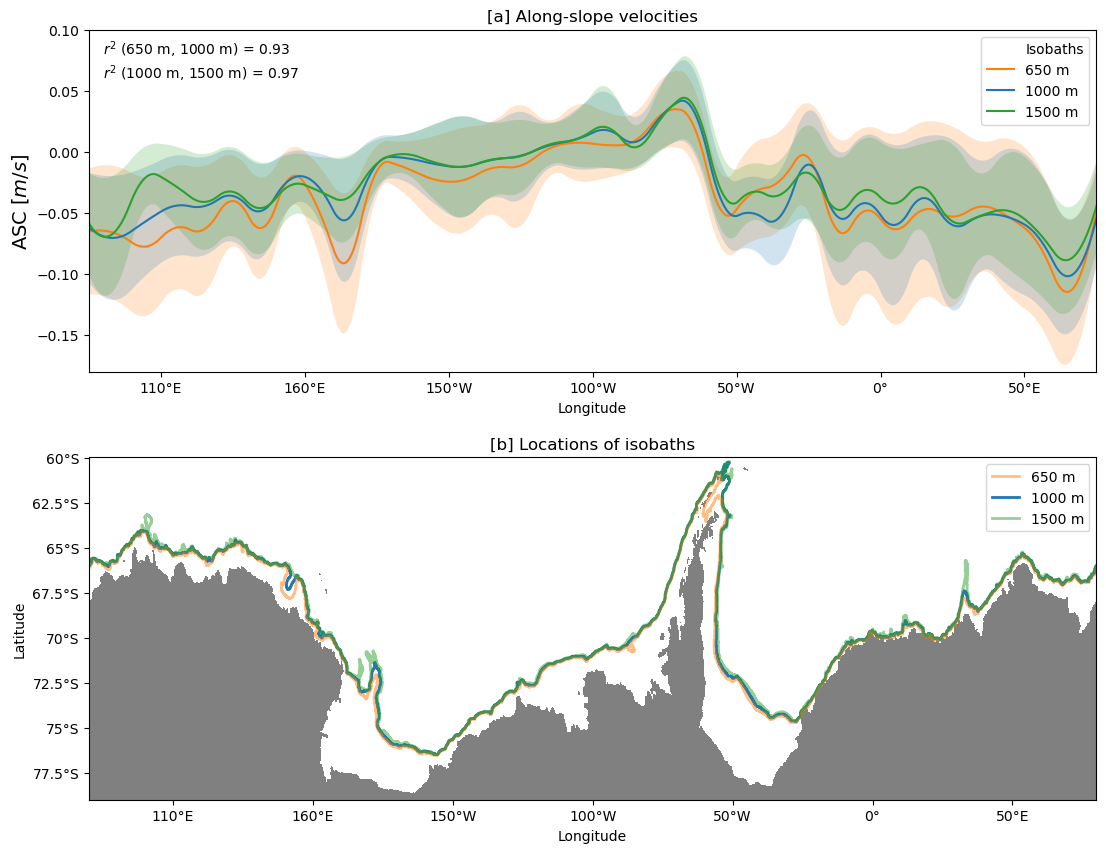

In [55]:
## plot

plt.figure(figsize=(13,10))
plt.subplots_adjust(hspace=0.25)

ax0 = plt.subplot(2,1,1)
#650m and std
plt.plot([],[],color='w',label='Isobaths')
plt.plot(ASC_650m_mean_z200_degs.lon_along_contour_bins,ASC_650m_mean_z200_degs,label='650 m',color='tab:orange')
plt.fill_between(ASC_650m_mean_z200_degs.lon_along_contour_bins, y1=ASC_650m_mean_z200_degs-ASC_650m_mean_z200_std_degs, \
                 y2=ASC_650m_mean_z200_degs+ASC_650m_mean_z200_std_degs,alpha=0.2,color='tab:orange',edgecolor='none')

#1000 m and std
plt.plot(ASC_1000m_mean_z200_degs.lon_along_contour_bins,ASC_1000m_mean_z200_degs,label='1000 m',color='tab:blue')
plt.fill_between(ASC_1000m_mean_z200_degs.lon_along_contour_bins, y1=ASC_1000m_mean_z200_degs-ASC_1000m_mean_z200_std_degs, \
                 y2=ASC_1000m_mean_z200_degs+ASC_1000m_mean_z200_std_degs,alpha=0.2,color='tab:blue',edgecolor='none')

plt.plot(ASC_1500m_mean_z200_degs.lon_along_contour_bins,ASC_1500m_mean_z200_degs,label='1500 m',color='tab:green')
plt.fill_between(ASC_1500m_mean_z200_degs.lon_along_contour_bins, y1=ASC_1500m_mean_z200_degs-ASC_1500m_mean_z200_std_degs, \
                 y2=ASC_1500m_mean_z200_degs+ASC_1500m_mean_z200_std_degs,alpha=0.2,color='tab:green',edgecolor='none')
plt.legend()
plt.ylabel(r'ASC [$m/s$]',fontsize=14)
plt.xlim(-275,75)
plt.ylim(-0.18,0.1)
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude')
plt.title('[a] Along-slope velocities')
plt.text(-270,0.08,r'$r^2$ (650 m, 1000 m) = ' + str(np.round(R2_1000m_650m_Cmean,2).values))
plt.text(-270,0.06,r'$r^2$ (1000 m, 1500 m) = ' + str(np.round(R2_1000m_1500m_Cmean,2).values))

ax1 = plt.subplot(2,1,2)
plt.contourf(depth0.xt_ocean,depth0.yt_ocean,depth0,levels=[0,1],colors='grey')
plt.plot(VELs_650m.lon_along_contour.isel(time=0),VELs_650m.lat_along_contour.isel(time=0),color='tab:orange',linewidth=2,label='650 m',alpha=0.5)
plt.plot(VELs_1000m.lon_along_contour.isel(time=0),VELs_1000m.lat_along_contour.isel(time=0),color='tab:blue',linewidth=2,label='1000 m',zorder=0)
plt.plot(VELs_1500m.lon_along_contour.isel(time=0),VELs_1500m.lat_along_contour.isel(time=0),color='tab:green',linewidth=2,label='1500 m',alpha=0.5)
plt.ylim(-79,-60);plt.xlim(-280,80);plt.legend()
ax1.xaxis.set_major_formatter(LongitudeFormatter()); plt.xlabel('Longitude')
ax1.yaxis.set_major_formatter(LatitudeFormatter()); plt.ylabel('Latitude')
plt.title('[b] Locations of isobaths')

plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/ASC_3_isobaths_full_depth.png',dpi=300,bbox_inches='tight')